# Etivity 1
## Name: Martin Power
## ID      : 9939245


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import math
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns

%matplotlib inline

### Reference Functions Provided by Template Notebook

In [2]:
def h(x,w):
    #Perceptron model: the sign of the dot product of weights and input vector determines the class allocation
    bias = np.array([1])
    return np.sign(w.T.dot(np.concatenate((bias,x))))

In [3]:
def point_on_boundary(weights, x):
    # Return the y-position on the boundary based on given x-position
    return -(weights[0]+weights[1]*x)/weights[2]

In [4]:
def decision_boundary(weights, x_min, x_max):
    # Return two points on the decision boundary
    # MPP return [pointOnBoundary(x_min), pointOnBoundary(x_max)] < -- Code typo
    return [point_on_boundary(weights, x_min), point_on_boundary(weights, x_max)]

In [5]:
def pla_orig(training_in, training_out, weights):
    bias = np.array([1])
    iterations=0
    while True:
        errors = 0;
        for x,y in zip(training_in, training_out):
            if (h(x,weights)!=y):
                iterations+=1;
                weights = weights + y*(np.concatenate((bias,x)))
                errors+=1;
        if (errors == 0):
            break
    return weights, iterations

In [6]:
def calc_error(training_in, training_out, weights):
    # Calculate the classification error as the fraction of training samples that are misclassified
    errors=0
    for x,y in zip(training_in, training_out):
        if (h(x,weights)!=y):
            errors+=1;
    return errors/len(training_in)

### Additional Helper Functions

In [7]:
# Same functionality as pla() but with a max_iterations field 
# to allow the function to exit gracefully if not converging
# on a hypothesis that delivers zero errors
def pla_w_limit(training_in, training_out, weights, max_iterations=1000):
    bias = np.array([1])
    iterations=0
    while True:
        errors = 0;
        for x,y in zip(training_in, training_out):
            if (h(x,weights)!=y):
                iterations+=1;
                weights = weights + y*(np.concatenate((bias,x)))
                errors+=1;
        if (errors == 0):
            break
        
        # If results are not converging after maximum iterations are reached, exit
        if (iterations>=max_iterations):
            break
            
    return weights, iterations

In [8]:
def print_dataset(X, y):
    # Plot the dataset
    
    # Assign colours based on the labels (1,-1) = (steelblue,darkred)
    colors = ['steelblue' if label == 1 else 'darkred' for label in y]
       
    # Plot Training Data
    plt.rcParams["figure.figsize"] = (10, 5) 
    plt.title("Dataset")
    plt.scatter(X[:,0], X[:,1], color=colors) 
    
    plt.show() 

In [9]:
def plot_data_w_boundary(X, y, weights):
    # Print the data with a line representing the decision boundary
    y_bound = np.zeros([2])
    X_bound = np.zeros([2])
    
    # Get min and max X Coordinate in the Data Set    
    X_bound[0] = X[:,0].min()
    X_bound[1] = X[:,0].max()

    # Get the Y coordinates for min and max X
    y_bound[0], y_bound[1] = decision_boundary(weights, X_bound[0], X_bound[1])
    
    # Assign colours based on the labels (1,-1) = (steelblue,darkred)
    colors = ['steelblue' if label == 1 else 'darkred' for label in y]
       
    # Plot Training Data
    plt.rcParams["figure.figsize"] = (10, 5) 
    plt.title("Dataset with Decision Boundary")
    plt.scatter(X[:,0], X[:,1], color=colors) 
    
    # Plot Decision Boundary
    plt.plot(X_bound, y_bound, linestyle='dashed', color='black')
    
    plt.show() 

In [10]:
# NOTE: In the following function, eout is effectively the test set error and not considered the true probabilistic Eout
def run_pla(training_in, training_out, test_in, test_out, max_iterations=1000):
    # Create and initialize weights
    weights = np.zeros([X.shape[1]+1,])
    
    eins=[]
    eouts=[]
    iterations=0
    bias = np.array([1])
    
    while True:
        errors = 0;
        for x,y in zip(training_in, training_out):
            if (h(x,weights)!=y):
                iterations+=1;
                weights = weights + y*(np.concatenate((bias,x)))
                errors+=1;
                
                ein  = calc_error(training_in, training_out, weights)
                eout = calc_error(test_in, test_out, weights)

        
                eins.append(ein)
                eouts.append(eout)
                                
        if (errors == 0):
            break
        
        # If results are not converging after maximum iterations are reached, exit
        if (iterations>=max_iterations):
            break   

    return weights, iterations, eins, eouts

In [11]:
# NOTE: In the following function, eout is effectively the test set error and not considered the true probabilistic Eout
def run_pocket(training_in, training_out, test_in, test_out, max_iterations=1000):
    # Create and initialize weights
    weights = np.zeros([X.shape[1]+1,])
    pocket_weights = np.zeros([X.shape[1]+1,])
    
    pocket_ein = 1.0
    
    eins=[]
    eouts=[]
    iterations=0
    bias = np.array([1])
    
    while True:
        errors = 0;
        for x,y in zip(training_in, training_out):
            if (h(x,weights)!=y):
                iterations+=1;
                weights = weights + y*(np.concatenate((bias,x)))
                errors+=1;
                
                ein = calc_error(training_in,training_out, weights)
                
                # Update Weights and Ein if new value is better than old value
                if(ein<pocket_ein):
                    pocket_weights = weights
                    pocket_ein = ein
                
                eout = calc_error(test_in, test_out, pocket_weights)
        
                eins.append(pocket_ein)
                eouts.append(eout)
                                
        if (errors == 0):
            break
        
        # If results are not converging after maximum iterations are reached, exit
        if (iterations>=max_iterations):
            break   

    return pocket_weights, iterations, eins, eouts

In [12]:
# Plot Probabilities and Hoeffing Bound as per example in exercise 1.10
# Pass in dataset and weights and repeat value and function will then 
# plot probabilities and bounds for a variety of values of N
def hoeffding_plot(X, y, weights, repeats=100):

    N = [1,10,50,100,200,300,500,1000]

    for n in N:
        d_ein = np.empty((repeats))
        d_eout = np.empty((repeats))
        d_abs = []

        test_size = n/len(X)
        for i in range(repeats):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
            ein  = calc_error(X_test, y_test, weights)
            eout = calc_error(X_train, y_train, weights)
            diff = abs(ein-eout)
            d_ein[i] = ein
            d_eout[i] = eout
            d_abs.append(diff)


        ein_avg  = f"Ein(avg)  = {d_ein.mean():.3f}"
        eout_avg = f"Eout(avg) = {d_eout.mean():.3f}"

        prob_epsilon=[]
        epsilons = np.arange(0, 1, 0.01)
        for e in epsilons:
            prob_epsilon.append(len([1 for i in d_abs if i > e])/len(d_abs))

        bound_label='Hoeffding Bound for N='+str(n)
        prob_label = 'P[abs(Ein-Eout)>e] for N='+str(n)
        title = 'N='+str(n)+" Repeats="+str(repeats)
        plt.figure()
        plt.plot(epsilons, prob_epsilon,label=prob_label)
        plt.plot(epsilons, [2*math.exp(-2*e**2*n) for e in epsilons],label=bound_label)
        plt.legend()
        plt.text(0.8, 1.5, ein_avg+"\n"+eout_avg)
        plt.xlabel('Epsilon')
        plt.title(title)
        plt.show


## Task 1
* Load bank_et1.csv into a Pandas dataframe. 
* Examine the first few data rows and the last few data rows. 
* Identify an attribute that can be the target/dependable variable for 2-class classification. 
* Follow the examples in the provided notebook “Lab 1 - Exploratory Data Analysis. ipynb ” (see section Material, Resources and Online Meetings below).

In [13]:
df = pd.read_csv('./bank_et1.csv')

print("Numer of Samples  in Dataset:\t",df.shape[0])
print("Numer of Features in Dataset:\t",df.shape[1])


Numer of Samples  in Dataset:	 2000
Numer of Features in Dataset:	 20


In [14]:
# Examine the first few data rows
# Print first 5 rows of the dataframe
df.head(5)

,Unnamed: 0,age,job,marital,education,default,balance,ratio_bal_ln,ratio_ln_inc,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
0,0,32,technician,single,tertiary,no,392,1.300134,0.473895,yes,no,cellular,1,apr,957,2,131,2,failure,no
1,1,39,technician,divorced,secondary,no,688,-0.193701,0.237021,yes,yes,cellular,1,apr,233,2,133,1,failure,no
2,2,59,retired,married,secondary,no,1035,1.334266,0.121981,yes,yes,cellular,1,apr,126,2,239,1,failure,no
3,3,47,blue-collar,married,secondary,no,398,0.362286,1.251328,yes,yes,cellular,1,apr,274,1,238,2,failure,no
4,4,54,retired,married,secondary,no,1004,0.072075,-0.533738,yes,no,cellular,1,apr,479,1,307,1,failure,no


In [15]:
# Examine the last few data rows.
# Print last 5 rows of the dataframe
df.tail(5)

,Unnamed: 0,age,job,marital,education,default,balance,ratio_bal_ln,ratio_ln_inc,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
1995,1995,20,student,single,NaN,no,2785,-2.170524,1.081071,no,no,cellular,16,sep,327,2,-1,0,NaN,yes
1996,1996,28,admin.,single,secondary,no,127,0.811788,1.134496,no,no,cellular,16,sep,1334,2,-1,0,NaN,yes
1997,1997,81,retired,married,primary,no,1154,0.504655,0.042190,no,no,telephone,17,sep,231,1,-1,0,NaN,yes
1998,1998,46,services,married,primary,no,4343,-0.965874,0.302708,yes,no,NaN,20,sep,185,1,-1,0,NaN,yes
1999,1999,40,entrepreneur,married,secondary,no,6403,-0.800893,1.066659,no,no,cellular,22,sep,208,2,-1,0,NaN,yes


#### Identify an attribute that can be the target/dependable variable for 2-class classification.

I am choosing a simple approach that is going to ignore any features with missing values and look for features that only have two unique values

The code below will print the names of any features that satisfy the following criteria:
* No missing values
* Only 2 unique values

In [16]:
for column in df:
    if((df[column].nunique()==2)and(df[column].isnull().sum()==0)):
        print(column)
        (df[column]=='no').sum()
        

default
housing
loan
subscribed


The test returns 4 different features that satisfy the condition to have only two states and to have no missing values

Inspecting these features, they all have "yes" or "no" values.

Before selecting one of these features, I want to see what the distribution of "yes" to "no" looks like in the dataset.

Intuitively, it would seem that you would want the "yes"/"no" split to be reasonably distributed such that one is not much more prevalent that the other

In [17]:
print("default   ","\tYes:\t",(df.default=='yes').sum(),"\tNo:\t",(df.default=='no').sum())
print("housing   ","\tYes:\t",(df.housing=='yes').sum(),"\tNo:\t",(df.housing=='no').sum())
print("loan      ","\tYes:\t",(df.loan=='yes').sum(),"\tNo:\t",(df.loan=='no').sum())
print("subscribed","\tYes:\t",(df.subscribed=='yes').sum(),"\tNo:\t",(df.subscribed=='no').sum())

default    	Yes:	 15 	No:	 1985
housing    	Yes:	 963 	No:	 1037
loan       	Yes:	 250 	No:	 1750
subscribed 	Yes:	 1000 	No:	 1000


"housing" and "subscribed" both have balanced, or almost balanced, distributions

Of these two,  I am choosing "subscribed" as the attribute for 2-class classification

### Task 1 Key Takeaways
* 4 Features had only 2 unique values, without missing values, and were candidates for 2-class classification
* "subscribed" had an even split of labels
* "subcribed" selected as the feature/attribute for 2-class classification


## Task 2

Follow the examples in the provided notebook “Lab 1 - Exploratory Data Analysis. ipynb ” (see section Material, Resources and Online Meetings below) to perform EDA of the bank data set.

* Calculate statistics for the numerical and categorical attributes.
* Use at least two different plotting techniques to plot the distribution of two numerical and two categorical attributes. Draw short conclusions (in a markdown cell).
* Generate two plots with the combined distribution of attributes and draw conclusions from them (in a markdown cell).
* Generate additional plots to identify two numerical attributes that can potentially be used for predicting the value of the dependent variable you chose in Task 1.
   - You won't find two numerical attributes that will perfectly classify a dependent variable. Pick the best you can find.

#### Numerical Attribute Statistics

In [18]:
# Calculate statistics for the numerical attributes.

# Print statistical summary for all numerical attributes
df.describe()

,Unnamed: 0,age,balance,ratio_bal_ln,ratio_ln_inc,day,duration,campaign,pdays,previous
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,999.500000,41.751500,1413.663500,0.241951,0.485030,13.851500,292.020500,1.909500,167.896000,2.561500
std,577.494589,12.723077,3131.224213,0.821604,1.075543,9.712189,221.557295,1.378862,131.754126,3.400735
min,0.000000,18.000000,-980.000000,-2.632068,-2.851405,1.000000,7.000000,1.000000,-1.000000,0.000000
25%,499.750000,32.000000,201.500000,-0.308018,-0.274181,5.000000,146.000000,1.000000,75.750000,1.000000
50%,999.500000,38.000000,551.000000,0.224099,0.487082,12.000000,236.000000,1.000000,182.000000,2.000000
75%,1499.250000,50.000000,1644.500000,0.806315,1.211896,23.000000,379.000000,2.000000,251.000000,3.000000
max,1999.000000,93.000000,81204.000000,2.961979,4.046914,31.000000,1823.000000,11.000000,854.000000,55.000000


#### Categorical Attribute Statistics

In [19]:
# From https://stackoverflow.com/questions/29803093/check-which-columns-in-dataframe-are-categorical
# The following code extracts the columns with categorical attributes

cat_var = [key for key in dict(df.dtypes)
             if dict(df.dtypes)[key] in ['object'] ] # Categorical Varible

for var in cat_var:
    print("\n****\t",var,"\t****")
    print("Total Values = \t",df[var].count(),"\n")
    print(df[var].value_counts())
    print("****************************")



****	 job 	****
Total Values = 	 1990 

management       461
technician       348
blue-collar      298
admin.           247
services         165
retired          162
student           96
unemployed        69
self-employed     64
entrepreneur      45
housemaid         35
Name: job, dtype: int64
****************************

****	 marital 	****
Total Values = 	 2000 

married     1111
single       674
divorced     215
Name: marital, dtype: int64
****************************

****	 education 	****
Total Values = 	 1896 

secondary    995
tertiary     684
primary      217
Name: education, dtype: int64
****************************

****	 default 	****
Total Values = 	 2000 

no     1985
yes      15
Name: default, dtype: int64
****************************

****	 housing 	****
Total Values = 	 2000 

no     1037
yes     963
Name: housing, dtype: int64
****************************

****	 loan 	****
Total Values = 	 2000 

no     1750
yes     250
Name: loan, dtype: int64
**********************

#### Conclusions from Categorical Statistics

* job
  - 10 values missing
  - Management is the most popular job with 23% of all applicants who state a job stating management

* marital
  - All values present
  - More than half married
  - Over 66% married at one point (married+divorced)

* education
  - "Primary" is the lowest value and suggests that 90% of people have attained secondary or tertiary education

* default
  - 99% have default set to "no"
  - This might be expected in bank applications as people who have defaulted will either not apply or will lie about it!

* housing
  - All values present and almost evenly split

* loan
  - All values present
  - 87.5% of applicants do not have a loan

* contact
  - 9.55% of values missing
  - Of values present, majority are cellular.
  - This suggests data is relatively recent as people have transitioned from landlines to mobiles

* month
  - All values present and all months present

* poutcome
  - All 50% are categorized as fail

* subsribed
  - All values present and 50/50 distribution of the two values

#### Numerical Attribute Plotting

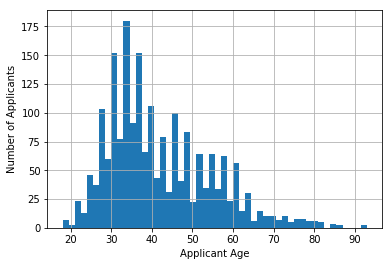

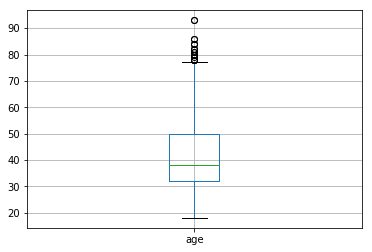

In [20]:
df['age'].hist(bins=50)
plt.xlabel('Applicant Age')
plt.ylabel('Number of Applicants')
plt.show()

df.boxplot(column='age');

#### "Age" Short Conclusion
* Median age is just under 40
* Under 80 is considered the maximum but there are several outliers above that up to past 90
* 18 is considered the minium and there are no outliers below this. This makes sense as it is probably illegal for childer to apply

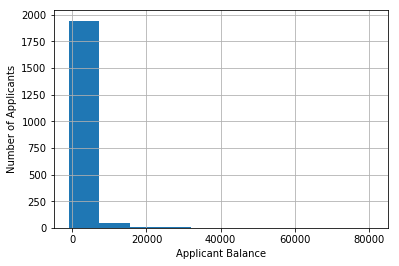

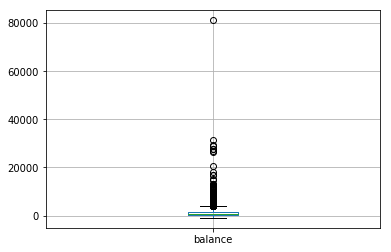

In [21]:
df['balance'].hist(bins=10)
plt.xlabel('Applicant Balance')
plt.ylabel('Number of Applicants')
plt.show()

df.boxplot(column='balance');

#### "Balance" Short Conclusion
* The majority of applicants have a low balance and the values are not very evenly distributed
* There is a substantial outlier with a balance about 80K
* Some applicants have negative balance

#### Combined Distribution of Age and Balance

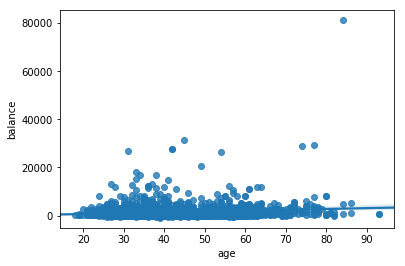

In [22]:
sns.regplot(x='age', y='balance', data=df);

#### Combined Distribution of Age and Balance Conculsion
* I picked these two variables as intuitively you would think that "balance" would increase with "age"
* The plot shows there is no increase in "balance" with "age"
* There is little or no correlation between "balance" and "age" with most applicants having a low "balance" regardless of their "age"

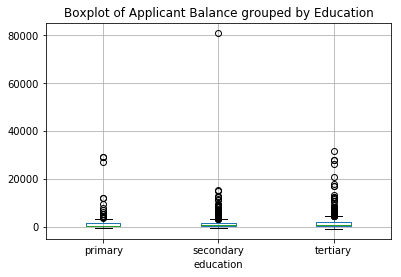

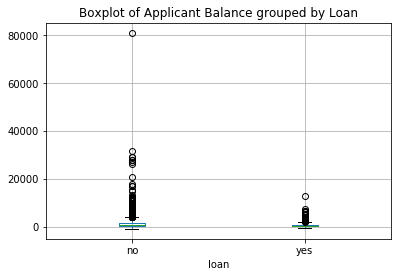

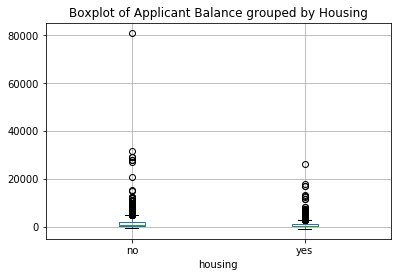

In [23]:
# Boxplots of ApplicantIncome, grouped by the categorical attribute Education
df.boxplot(column='balance', by='education')
plt.title('Boxplot of Applicant Balance grouped by Education')
plt.suptitle("") # get rid of the automatic 'Boxplot grouped by group_by_column_name' title


# Boxplots of ApplicantIncome, grouped by the categorical attribute Loan
df.boxplot(column='balance', by='loan')
plt.title('Boxplot of Applicant Balance grouped by Loan')
plt.suptitle("") # get rid of the automatic 'Boxplot grouped by group_by_column_name' title

# Boxplots of ApplicantIncome, grouped by the categorical attribute Housing
df.boxplot(column='balance', by='housing')
plt.title('Boxplot of Applicant Balance grouped by Housing')
plt.suptitle(""); # get rid of the automatic 'Boxplot grouped by group_by_column_name' title

Frequency Table for housing:
yes     963
no     1037
Name: housing, dtype: int64
         subscribed
housing            
no         0.768563
yes        0.210800


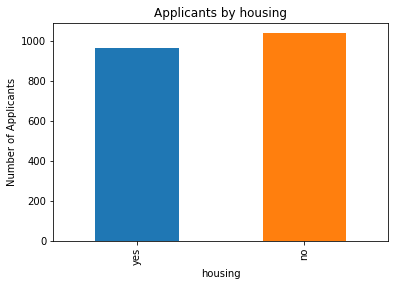

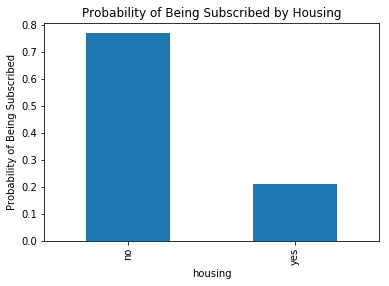

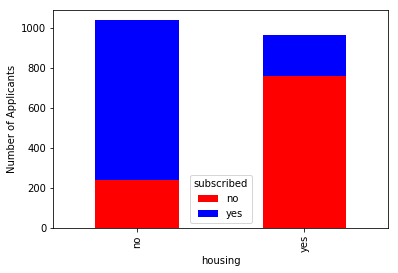

In [24]:
# Calculate statistics for the categorical attributes.

frequency_table = df['housing'].value_counts(ascending=True)
print('Frequency Table for housing:') 
print(frequency_table)

# Plot the frequency table for housing
frequency_table.plot(kind='bar')
plt.xlabel('housing')
plt.ylabel('Number of Applicants')
plt.title('Applicants by housing')

pivot_table = df.pivot_table(values='subscribed',
                       index=['housing'],
                       aggfunc=lambda x: x.map({'yes':1, 'no':0}).mean()) 

# Print pivot table
print(pivot_table)

# Plot pivot table
pivot_table.plot(kind='bar')
plt.xlabel('housing')
plt.ylabel('Probability of Being Subscribed')
plt.title('Probability of Being Subscribed by Housing')
plt.legend().set_visible(False) # we don't need the default legend

stacked_chart = pd.crosstab(df['housing'], df['subscribed'])
stacked_chart.plot(kind='bar', stacked=True, color=['red', 'blue'])
plt.ylabel('Number of Applicants')
plt.show()

#### Task 2 Combined Distribution Attribute Conclusions

* The distribution of housing between "yes" and "no" is almost 50/50 in the dataset
* However if you answered "no" to housing, you have a probability of 76.85% of being substribed versus just 21% if you answered "yes" to housing
* There you are over 3.5 times more likely to be subscribed if you answer "no" to housing
* The stacked charts show clearly that the majority of applicants who answered "no" to housing are subscribed and that the majority who answered "yes" to housing are not subscribed

## Search for Two Numerical Attributes for Predicting Value of "subscribed"
* For this search I am only using numerical data
  - Therefore drop column[0] which is only an index
  - Also drop all categorical attributes

In [25]:
# Drop column 0
df = df.drop(df.columns[0], axis=1)

# Drop Categorical Columns
df = df.drop(columns = ['poutcome', 'month', 'contact', 'loan', 'housing', 'default', 'education', 'marital', 'job',])

df.head(5)

,age,balance,ratio_bal_ln,ratio_ln_inc,day,duration,campaign,pdays,previous,subscribed
0,32,392,1.300134,0.473895,1,957,2,131,2,no
1,39,688,-0.193701,0.237021,1,233,2,133,1,no
2,59,1035,1.334266,0.121981,1,126,2,239,1,no
3,47,398,0.362286,1.251328,1,274,1,238,2,no
4,54,1004,0.072075,-0.533738,1,479,1,307,1,no


#### Pairplots of Numerical Data

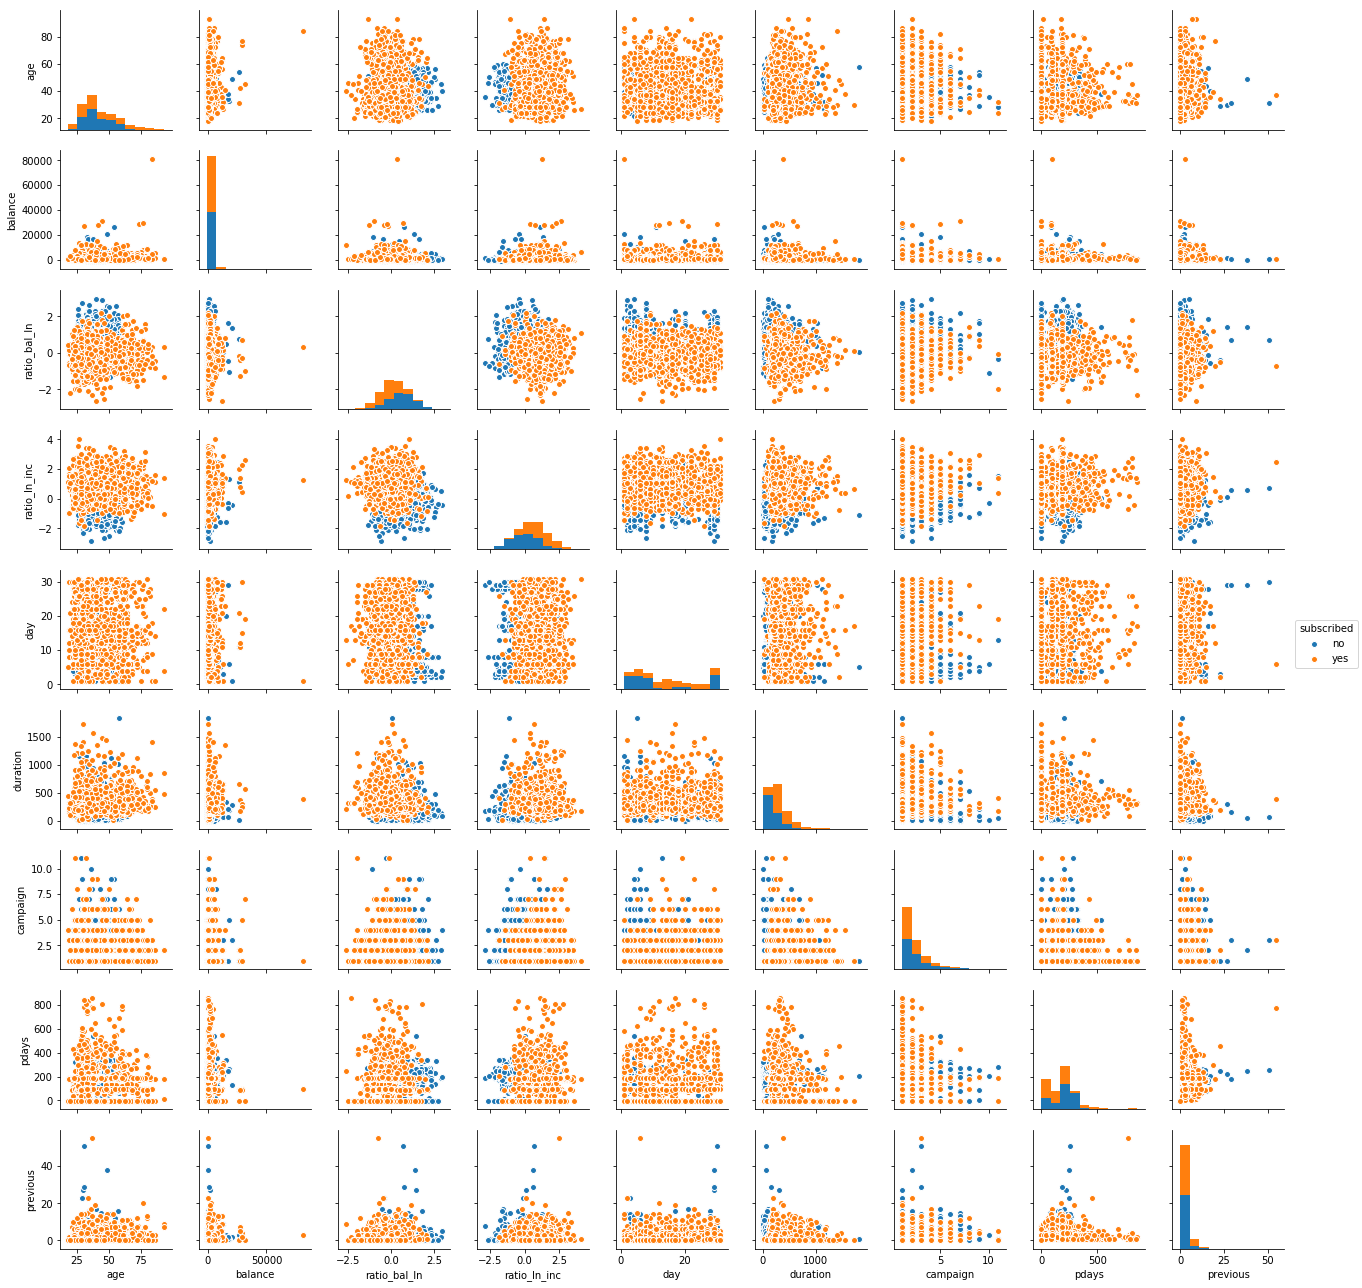

In [26]:
sns.pairplot(df, hue = 'subscribed', size=2);

#### Pairplot Initial Analysis

* In the plots above, I am looking for two variables that appear to be clustered similar to the "make_blobs" dataset and that would be suitable for using with the perceptron learning algorithm
* The following attributes look promising - "age", "ratio_bal_ln", "ratio_ln_inc"
* As there are a large number of plots, I am going to re-plot the pair plots just using the attributes of interest as this will allow easier visual inspection

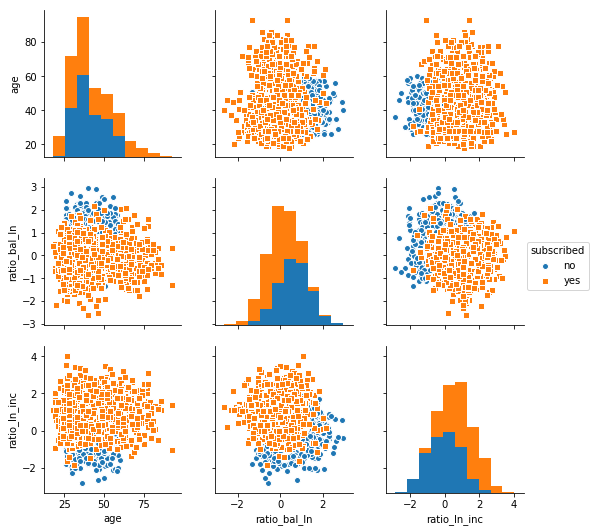

In [27]:
sns.pairplot(df, hue = 'subscribed', vars=["age", "ratio_bal_ln", "ratio_ln_inc"], markers=["o", "s"]);

#### Pairplot Additional Analysis

* "ratio_bal_ln" and  "ratio_ln_inc" look like the best candidates for the perceptron learning algorithm


## Task 3

Consider the two numerical attributes picked in Task 2 and describe (in a markdown cell) how a perceptron can be used to perform 2-class classification. Use the following terms in your description:

* Input space
* Output space
* Unknown target function
* Data set
* Hypothesis set
* Final Hypothesis
* In-sample error
* Out-of-sample error

### Task 3 Key Takeaways

The perceptron is an algorithm that learns a function to map a multi-dimensional real input to a binary output. For our task, the **_input space_** is a set of 2D points defined by **_ratio_bal_ln_** and **_ratio_ln_inc_**. Each of the points falls into either the "yes" or "no" category for the "subscribed" feature. As there are only 2 labels for "subscribed", the allows "yes"/"no" to be mapped to the integer values "+1/-1" and reduce the problem to a binary classifiction task (where +1/-1 is used instead of 0/1).  This now becomes the **_output space_** for our algorithm.

The **_output space_** has only two possible values - +1/-1 - and the task of the algorithm is to learn the **_unknown target function_** that will map every 2D point representing **_ratio_bal_ln_** and **_ratio_ln_inc_** into the correct "yes/no" class. For a 2D input space like this problem, the **_unkown target function_** is simply a line that divides all points on one side of the line into one class and all points on the other side of the line into the other class. Therefore, the **_data set_** needs to be linearly separable for the perceptron algorithm to achieve 100% accuracy. If the **_data set_** is not linearly separable then the algorithm will not be able to achieve acceptable accuracy and famously, for functions such as XOR, it may not be able to learn a functions that will classify the point correctly.

The **_data set_**, D, can be split into a training set and a test set. The training set can be used to learn the **_unkown target function_** and the test set can be used to see how the learned function performs on data is has never seen before. The performance obtained using the test set does not guarantee that similar performance will be achieved when the learned function is applied to data that resides outside of the **_data set_**, D

The algorithm will choose what it determines to be the best candidate function from the **_hypothesis set_** H. For our example and this algorithm, the **_hypothesis set_** contains the infinite combination of lines that can be drawn on the 2D plane. It is up to the algorithm to find the best line that classifies the data and this will be considered the **_final hypothesis_**.

The determination of the best line is the line that produces the lowest **_In-sample error_** which corresponds to the fraction of that dataset where the learned function disagrees with the **_unkown target function_**. An **_in-sample error_** of 0.0 means that the two function agree completely whereas an **_in-sample error_** of 1.0 means that every sample gets misclassifed. For a binary classification task, an **_in-sample error_** of 0.5 is the lower bound on any function that wants to claim it has learned from the data as simply classifying all points in a balanced dataset to either "yes" or "no" would yield an **_in-sample error_** of 0.5.

To truly asses the quality of the learned function, the **_out-of-sample_** error needs to be considered. It cannot be empirically calculated like the **_in-sample error_** as this is unknown data. Instead it is a probabilistic measure that aims to give an indication on how the algorithm will perform on data it has not seen previously


## Task 4

Run the provided perceptron learning algorithm (PLA) on the dataset provided in the notebook. Take note of the number of iterations that were required to come to the final hypothesis and the final error. Once you are satisfied you understand these results, run the PLA algorithm on the dataset you have explored in the previous tasks (using the selected dependent variable and the two most promising numerical attributes/features). If results are unsatisfactory (if you don't get results at all, why would this be?), investigate how the PLA algorithm can be changed to improve the performance. Change the provided algorithm accordingly and plot estimates for P[Ein-Eout|>e]. Exercise 1.10 (see Python code below in the Resources section) gives an example of how you can create such plots. In the same plot add the Hoeffding Bound  and conclude whether or not the found results obey the Hoeffding Equation (in a markdown cell). Draw conclusions on whether or not you have found proof that learning is possible (in a markdown cell).

## Blob Dataset Initial Experimentation

Based on suggestion, using Blob datset for initial experimentation


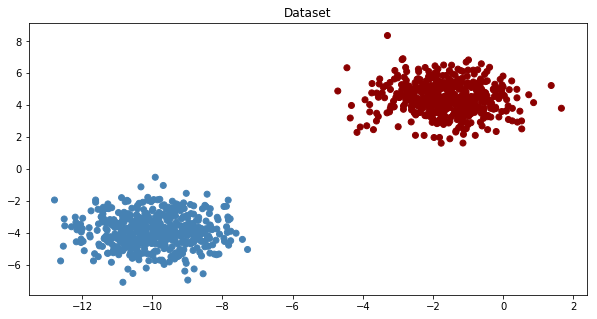

In [28]:
# Create and display datset
X, y = make_blobs(n_samples=1000, centers=2, n_features=2, random_state=1)

y = [yy if yy == 1 else -1 for yy in y] 

# Print the dataset
print_dataset(X, y)

# Split into test set and train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

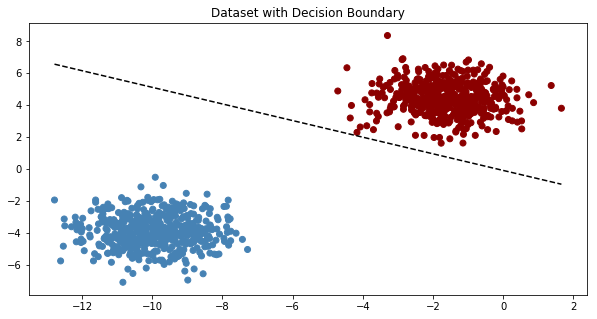

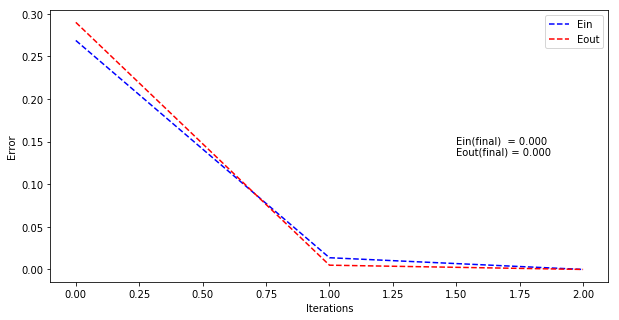

In [29]:
pla_weights, iterations, eins, eouts = run_pla(X_train, y_train, X_test, y_test, max_iterations=1000)

plot_data_w_boundary(X, y, pla_weights)

ein_final  = f"Ein(final)  = {eins[-1]:.3f}"
eout_final = f"Eout(final) = {eouts[-1]:.3f}"

plt.plot(eins, linestyle='dashed', color='blue', label="Ein")
plt.plot(eouts, linestyle='dashed', color='red', label="Eout")
plt.text(iterations/2, eins[0]/2, ein_final+"\n"+eout_final)
plt.xlabel("Iterations")
plt.ylabel("Error")
plt.legend()
plt.show()

### Blob Dataset Key Takeaways
* Data is linearly separable
* Perceptron Learning Algorithm delivers a 0% Error Rate
* Algorithm converges after 2 iterations


## Moons Dataset Initial Experimentation

Moons dataset is not linearly separable. Therefore, Perceptron Learning algorithm will not deliver a 0% error rate.

Pocket Learning algorithm *should* help achieve a better error rate

Running both algorithms to compare the performance

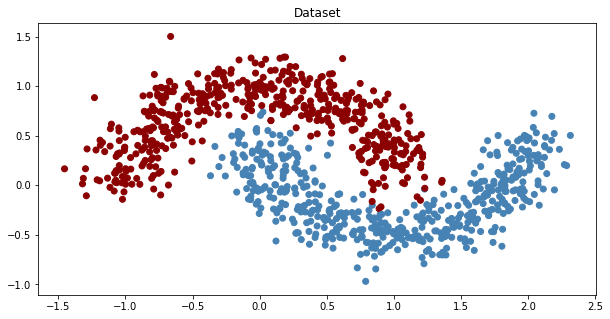

In [30]:
# Create Moons dataset and display
X, y = make_moons(n_samples=1000, noise=0.15, random_state=1)

y = [yy if yy == 1 else -1 for yy in y]

# Print the dataset
print_dataset(X, y)

# Split into test set and train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

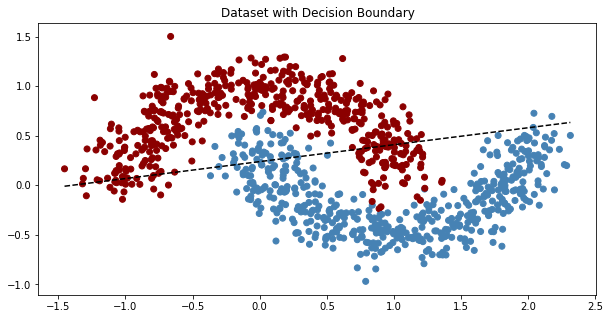

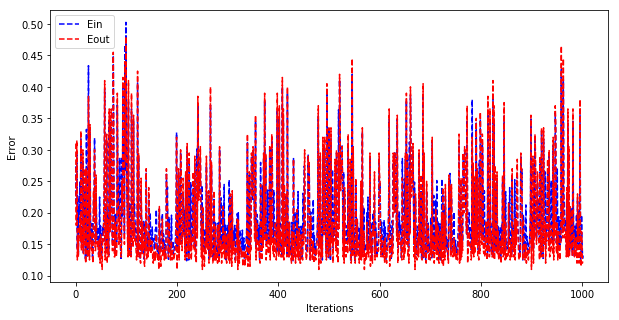

Iterations= 1003
Ein(final) = 	 0.13625 Eout(final)= 	 0.12
Ein(min)   = 	 0.12375 Eout(min)  = 	 0.11
Ein(max)   = 	 0.5025 Eout(max)  = 	 0.48


In [31]:
# Run PLA on Moons
pla_weights, iterations, eins, eouts = run_pla(X_train, y_train, X_test, y_test, max_iterations=1000)

plot_data_w_boundary(X, y, pla_weights)

plt.plot(eins, linestyle='dashed', color='blue', label="Ein")
plt.plot(eouts, linestyle='dashed', color='red', label="Eout")
plt.xlabel("Iterations")
plt.ylabel("Error")
plt.legend()
plt.show()

print("Iterations=",iterations)
print("Ein(final) = \t",eins[-1],    "Eout(final)= \t",eouts[-1])
print("Ein(min)   = \t",np.min(eins),"Eout(min)  = \t",np.min(eouts))
print("Ein(max)   = \t",np.max(eins),"Eout(max)  = \t",np.max(eouts))

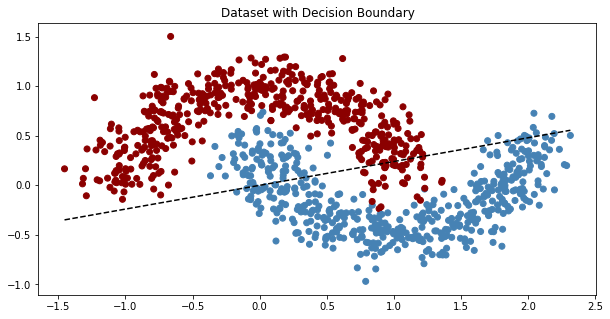

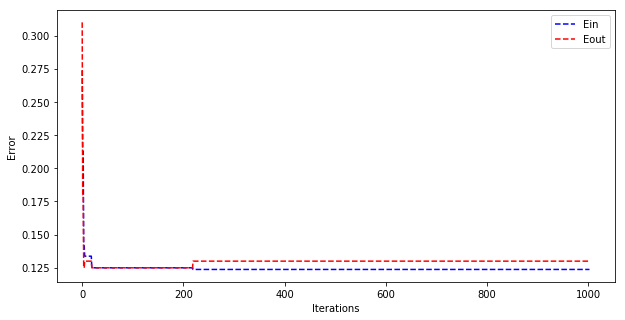

Total Iterations = 1003 Pocket Weight Iteration =  219
Ein(final) = 	 0.12375 Eout(final)= 	 0.13
Ein(min)   = 	 0.12375 Eout(min)  = 	 0.125
Ein(max)   = 	 0.27375 Eout(max)  = 	 0.31


In [32]:
# Run Pocket Algorithm on Moons
pocket_weights, iterations, eins, eouts = run_pocket(X_train, y_train, X_test, y_test, max_iterations=1000)

plot_data_w_boundary(X, y, pocket_weights)

plt.plot(eins, linestyle='dashed', color='blue', label="Ein")
plt.plot(eouts, linestyle='dashed', color='red', label="Eout")
plt.xlabel("Iterations")
plt.ylabel("Error")
plt.legend()
plt.show()

print("Total Iterations =",iterations, "Pocket Weight Iteration = ",np.argmin(eins))
print("Ein(final) = \t",eins[-1],    "Eout(final)= \t",eouts[-1])
print("Ein(min)   = \t",np.min(eins),"Eout(min)  = \t",np.min(eouts))
print("Ein(max)   = \t",np.max(eins),"Eout(max)  = \t",np.max(eouts))

### Moons Dataset Key Takeaways
* Data is *NOT* linearly separable
* Perceptron Learning Algorithm delivers an Ein of  0.13625
* Pocket Learning Algorithm delivers an Ein of 0.12375
* Algorithms do not converge and reach the max_iteration limit set in the underlying functions
* Although the Pocket algorithm ran for 1003 iterations, the best weights were identified during iteration 219

## Bank Dataset

The two features being used to predict "subscribed" are not linearly separable so a 0% error rate is not expected

The PLA algorithm is not expected to perform as well as the Pocket Algorithm for this dataset

Running both algorithms to compare the performance

In [33]:
#Shuffle the dataframe
df = df.sample(frac=1, random_state=42)

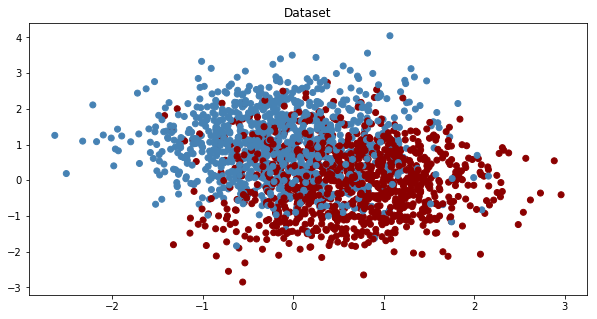

In [34]:
# Create the dataset from the dataframe
X = df[['ratio_bal_ln', 'ratio_ln_inc']].values
y_labels = df[['subscribed']].values
y = [1 if yy == 'yes' else -1 for yy in y_labels] 

# Print the Resulting Dataset
print_dataset(X, y)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

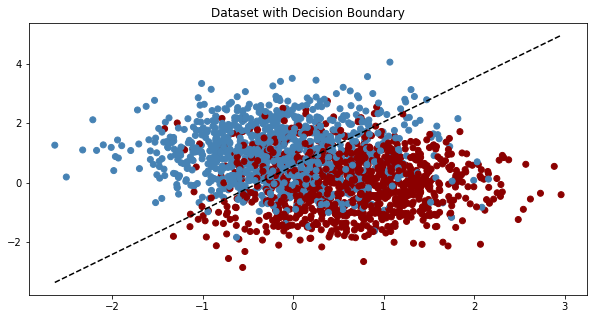

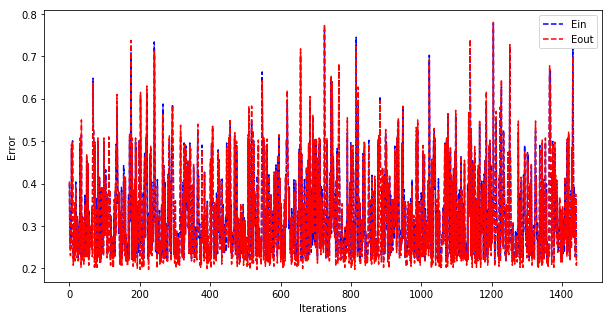

Iterations= 1443
Ein(final) = 	 0.230625 Eout(final)= 	 0.22
Ein(min)   = 	 0.22 Eout(min)  = 	 0.1975
Ein(max)   = 	 0.776875 Eout(max)  = 	 0.78


In [35]:
# Run PLA on Bank Dataset
pla_weights, iterations, eins, eouts = run_pla(X_train, y_train, X_test, y_test, max_iterations=1000)

plot_data_w_boundary(X, y, pla_weights)

plt.plot(eins, linestyle='dashed', color='blue', label="Ein")
plt.plot(eouts, linestyle='dashed', color='red', label="Eout")
plt.xlabel("Iterations")
plt.ylabel("Error")
plt.legend()
plt.show()

print("Iterations=",iterations)
print("Ein(final) = \t",eins[-1],    "Eout(final)= \t",eouts[-1])
print("Ein(min)   = \t",np.min(eins),"Eout(min)  = \t",np.min(eouts))
print("Ein(max)   = \t",np.max(eins),"Eout(max)  = \t",np.max(eouts))

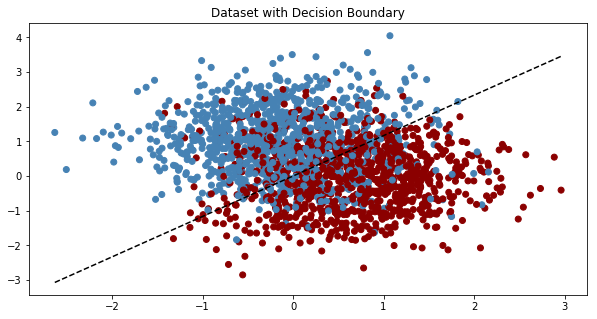

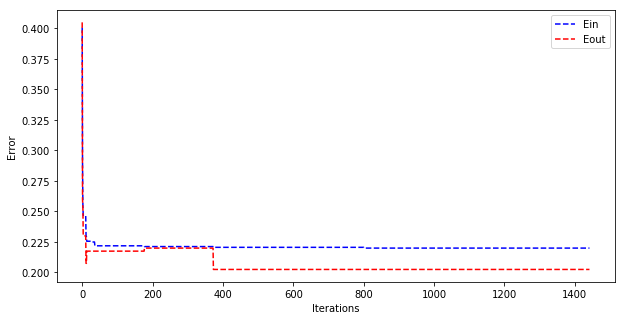

Total Iterations = 1443 Pocket Weight Iteration =  801
Ein(final) = 	 0.22 Eout(final)= 	 0.2025
Ein(min)   = 	 0.22 Eout(min)  = 	 0.2025
Ein(max)   = 	 0.400625 Eout(max)  = 	 0.405


In [36]:
# Run Pocket Algorithm on Bank Dataset
pocket_weights, iterations, eins, eouts = run_pocket(X_train, y_train, X_test, y_test, max_iterations=1000)

plot_data_w_boundary(X, y, pocket_weights)

plt.plot(eins, linestyle='dashed', color='blue', label="Ein")
plt.plot(eouts, linestyle='dashed', color='red', label="Eout")
plt.xlabel("Iterations")
plt.ylabel("Error")
plt.legend()
plt.show()

print("Total Iterations =",iterations, "Pocket Weight Iteration = ",np.argmin(eins))
print("Ein(final) = \t",eins[-1],    "Eout(final)= \t",eouts[-1])
print("Ein(min)   = \t",np.min(eins),"Eout(min)  = \t",np.min(eouts))
print("Ein(max)   = \t",np.max(eins),"Eout(max)  = \t",np.max(eouts))

#### Initial Results Analysis

* Perceptron Learning Algorithm
  - Using 1443 iterations a final Ein of 0.23 and Eout of 0.22 was achieved
  - Across the 1443 iterations, Ein varied from 0.22 to 0.776875
  - The plot of Ein and Eout shows that the values vary significantly between iterations
  - This means that the final value is in part a function of the number of iterations that the algorithm is allowed to go through
  - If max_iterations was set to a different value, the final value of Ein and the final weights could have been much worse
  
  
  
* Pocket Learning Algorithm
  - Using 1443 iterations a final Ein of 0.22 and Eout of 0.2025 wass achieved
  - This is a slight improvement on the Perceptron Learning algorithm although the Pocket Learning algorithm gives a more deterministic performance as the values of Ein and Eout do not vary as wildly as the Perceptron algorithm across iterations
  - Although 1443 iterations were used, it was iteration 801 that provided the weights for the chosen pocket weights
  - For data that is not linearly separable and that prevents the Perceptron algorithm from converging, the Pocket algorithm provides a deterministic way of finding the best performing weights across the chosen number of iterations



#### Probability Plots and Hoeffding Bound


Did learning occur?

From the textbook, the feasibility of is split into two questions
	* 1) Can we make sure Eout(g) is close enough to Ein(g)
	* 2) Can we make Ein(g) small enough?

The Hoeffding inequality addresses 1) . In order to apply the Hoeffding Inequality, the hypothesis must be fixed. Therefore, I am running the Pocket Algorithm to find a candidate hypothesis and fixing at this hypothesis.

Once the hypothesis is fixed, I will generate random datasets and check that the bound is valid for that hypothesis (Similar to as done in Exercise 1.10)

For question 2), can we make Ein(g) small enough? As the variables are not linearly separate we know that the Perceptron Learning algorithm and the Pocket algorithm will not deliver 0% error. The text book points out that there are cases where Ein(g) ~=0% will not be achieved (e.g. Financial forecasting) and that in those cases we are looking for a hypothesis that is right more often that it is wrong. 

The pocket algorithm delivered a hypothesis that delivered Eing(g) ~=21%. This is definitely better than 50% which is effectively the lower bound on performance but it is difficult to tell if this is close to the upper bound of achievable performance, assuming other algorithms or tools were used

Noting that *"LogisticRegression"* was imported in the first cell of the template notebook, I am going to run the dataset through this algorithm as see that performance is achieved and use that to compare to the Pocket algorithm to address question 2


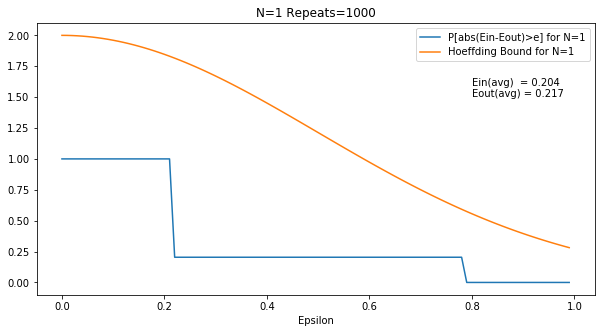

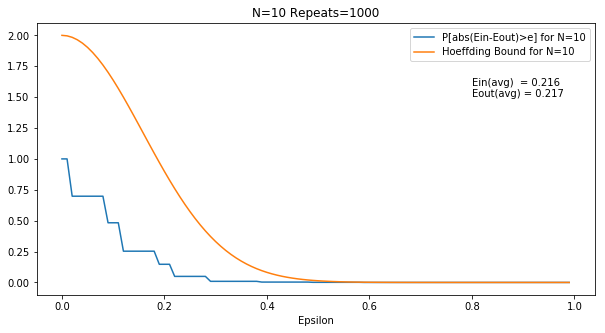

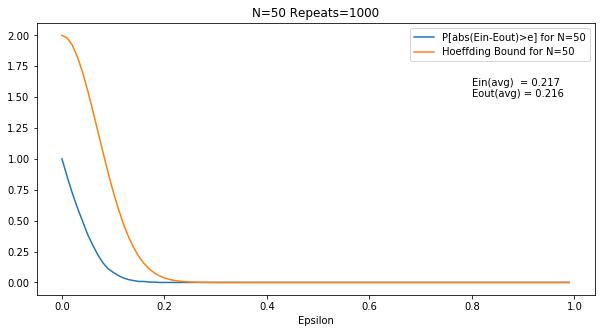

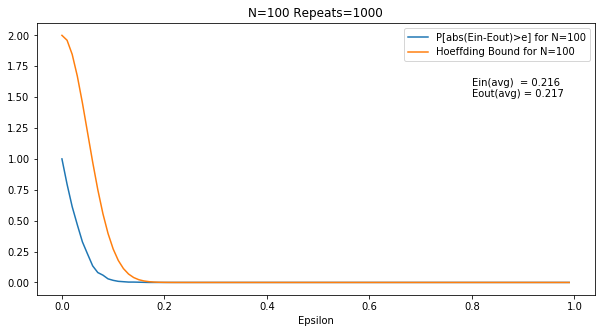

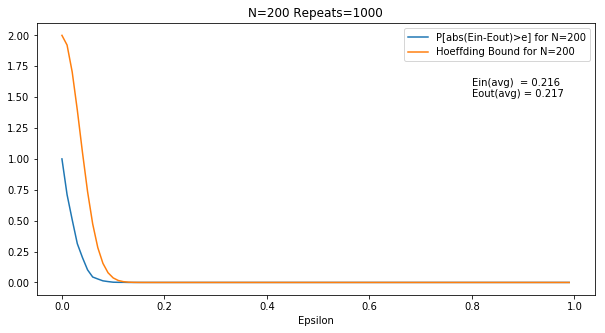

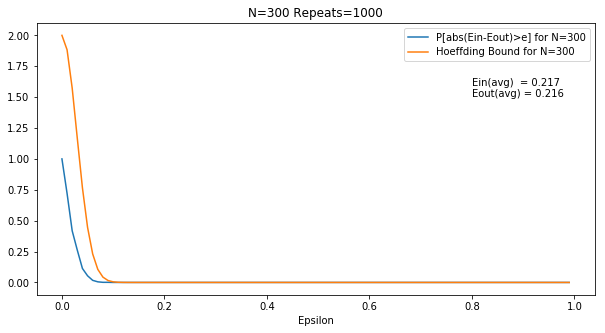

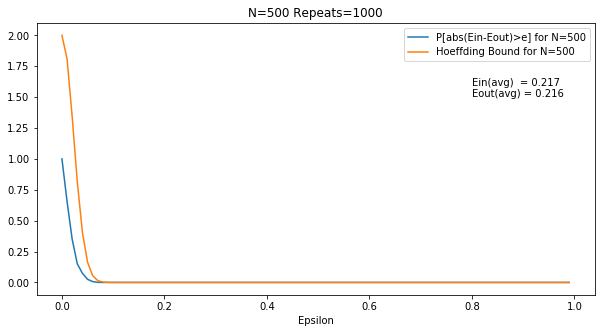

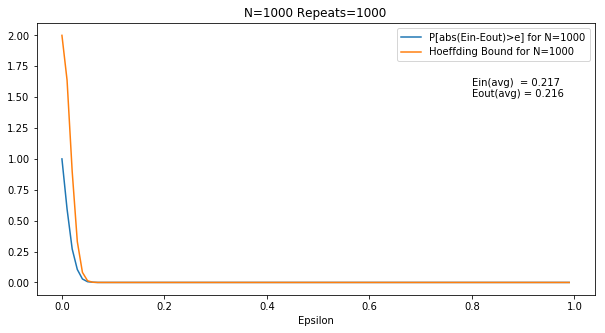

In [37]:
# Pass the weights for the chosen hypothesis and the dataset to a function
# that will generate random datasets and plot the performance versus the Hoeffding bound
hoeffding_plot(X,y,pocket_weights,repeats=1000)

### Running Logistic Regression
* Logisitic regression uses a sigmoid transformation as opposed to the step-like function used by the Perceptron
* Running logistic regression on the same dataset to see performance and compare to perceptron

In [39]:
# Example Code taken from https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

# Run Logistic Regression on the dataset to compare with performance achieved using Pocket algorithm
logreg = LogisticRegression()

# Fit to dataset
logreg.fit(X_train, y_train)

# Predict
y_hat = logreg.predict(X_test)

score_test = logreg.score(X_test, y_test)
score_train  = logreg.score(X_train, y_train)

# Substract scores from 1 to convert to Ein/Eout
etrain = 1 - score_train
etest = 1 - score_test

print("Logistic Regression Performance")
print("Etrain  =\t",etrain)
print("Etest = \t",etest)


Logistic Regression Performance
Etrain  =	 0.21999999999999997
Etest = 	 0.20499999999999996


### Task 4 Key Takeaways

The plots show that for a variety of values of N, the Hoeffding Inequality holds valid as the probability of abs[Ein(g) - Eout(g)] <= the Hoeffding Bound

As N increases, the values of Ein and Eout, on average, get closer together. There is no guarantee (deterministically) that Ein will always be close to Eout but we can say that probabilistically Ein will be close to Eout.

Therefore, the first question about the feasibility of learning is satisfied

For the second question, is Ein(g) small enough? The original hypothesis delivered an Ein of 22% and the Hoeffding plot function showed that Ein ranged from about 21.5% to 21.7% for larger value of N.

Running the same dataset through a Logistic Regression classifier returned an error of 21.99%. While by no means being exhaustive, this does show that the 22% achieved using the Pocket algorithm seems reasonable and could be considered to be in the region of what can be achieved using these attributes for the chosen target variable

In summary, there is proof that learning is possible and the results obtained suggest that learning occurred using the Pocket algorithm on the dataset
